### Import Libraries


In [1]:
import sys
import pathlib
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from ccc.coef import ccc

sys.path.append("../utils")
from split_utils import get_features_data

### Load Labeled Data


In [2]:
# load labeled data
labeled_data_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
labeled_data = get_features_data(labeled_data_path)
# labeled_data

### Creat esingle class model interpretations


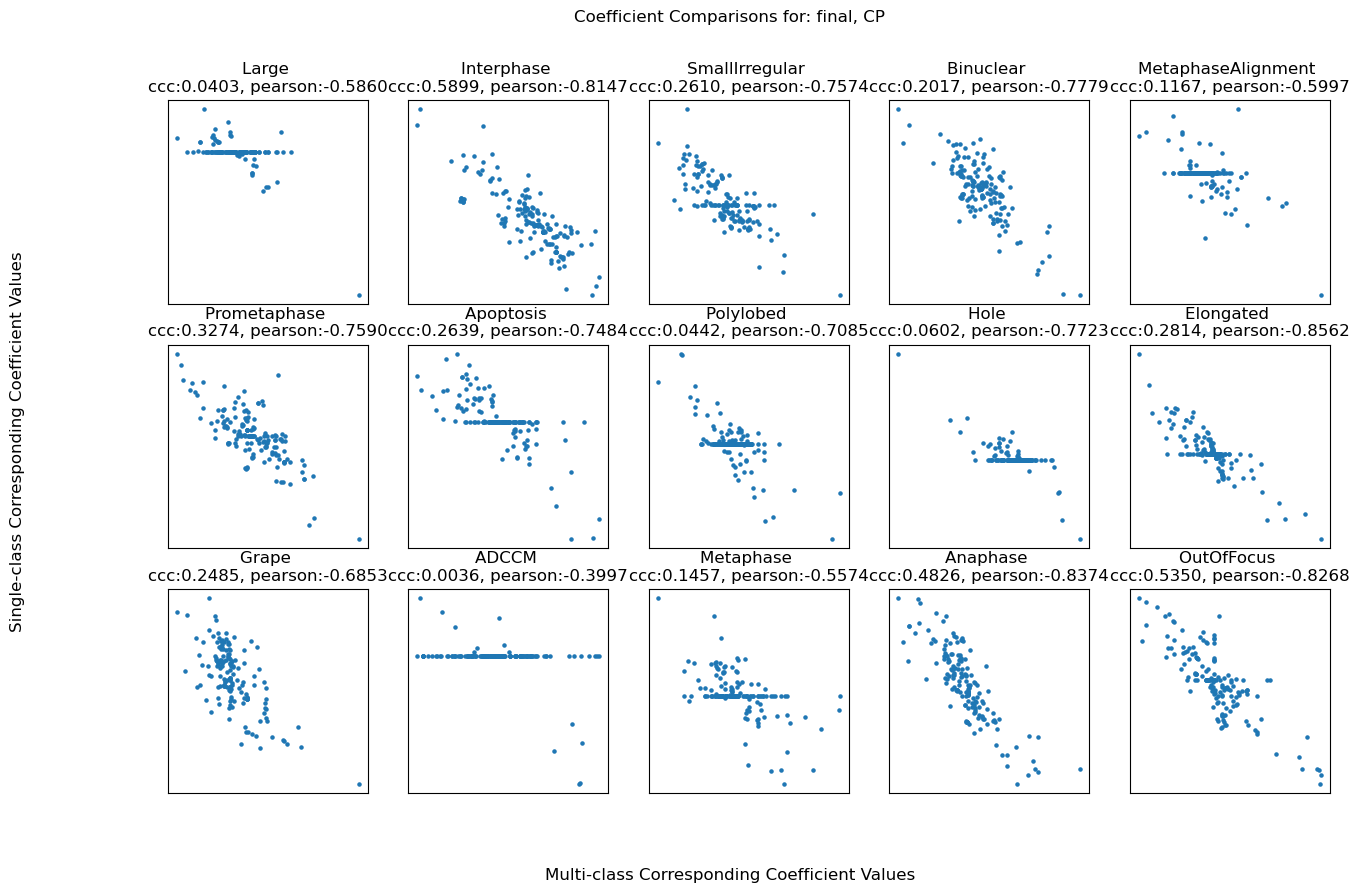

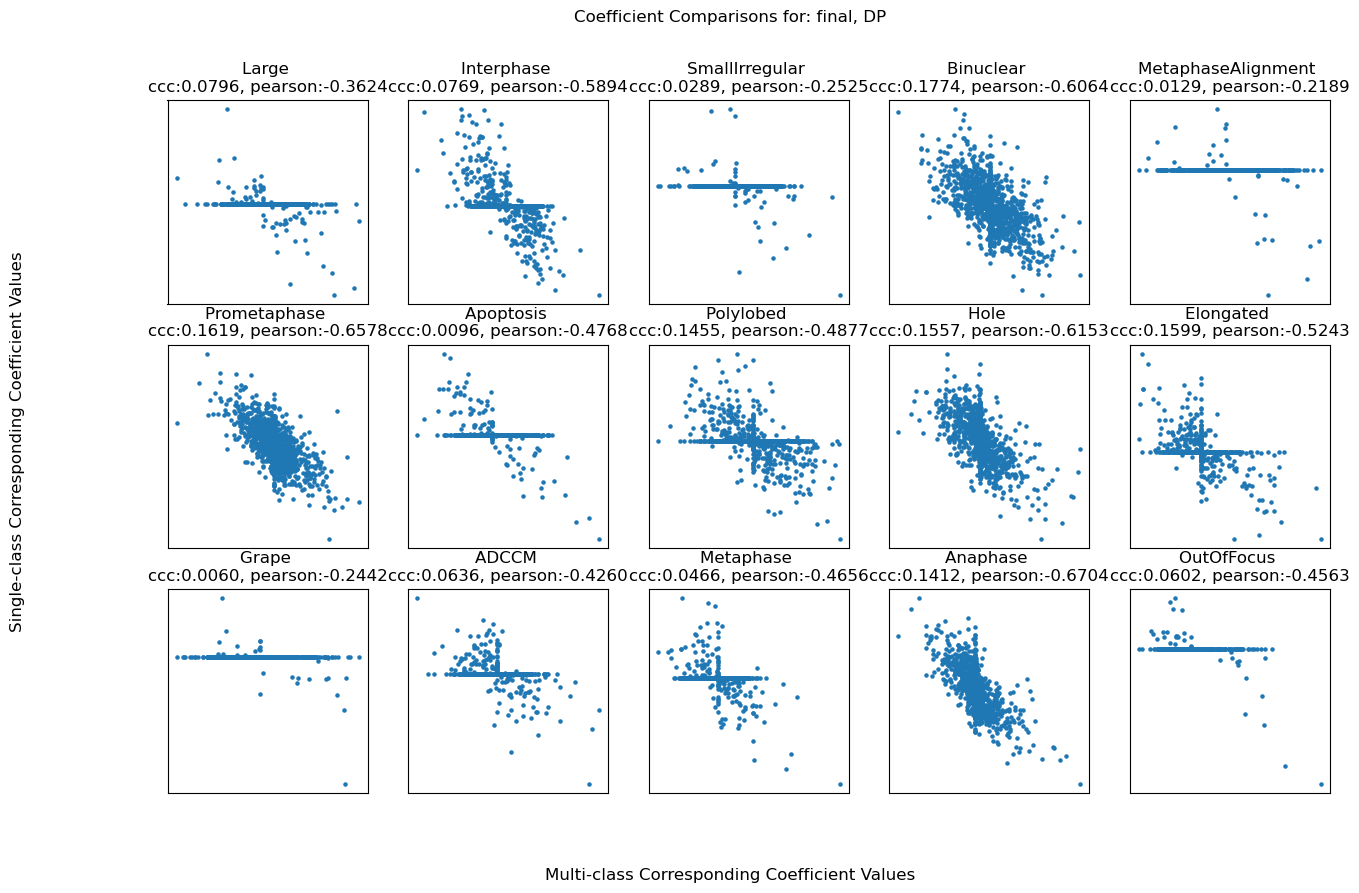

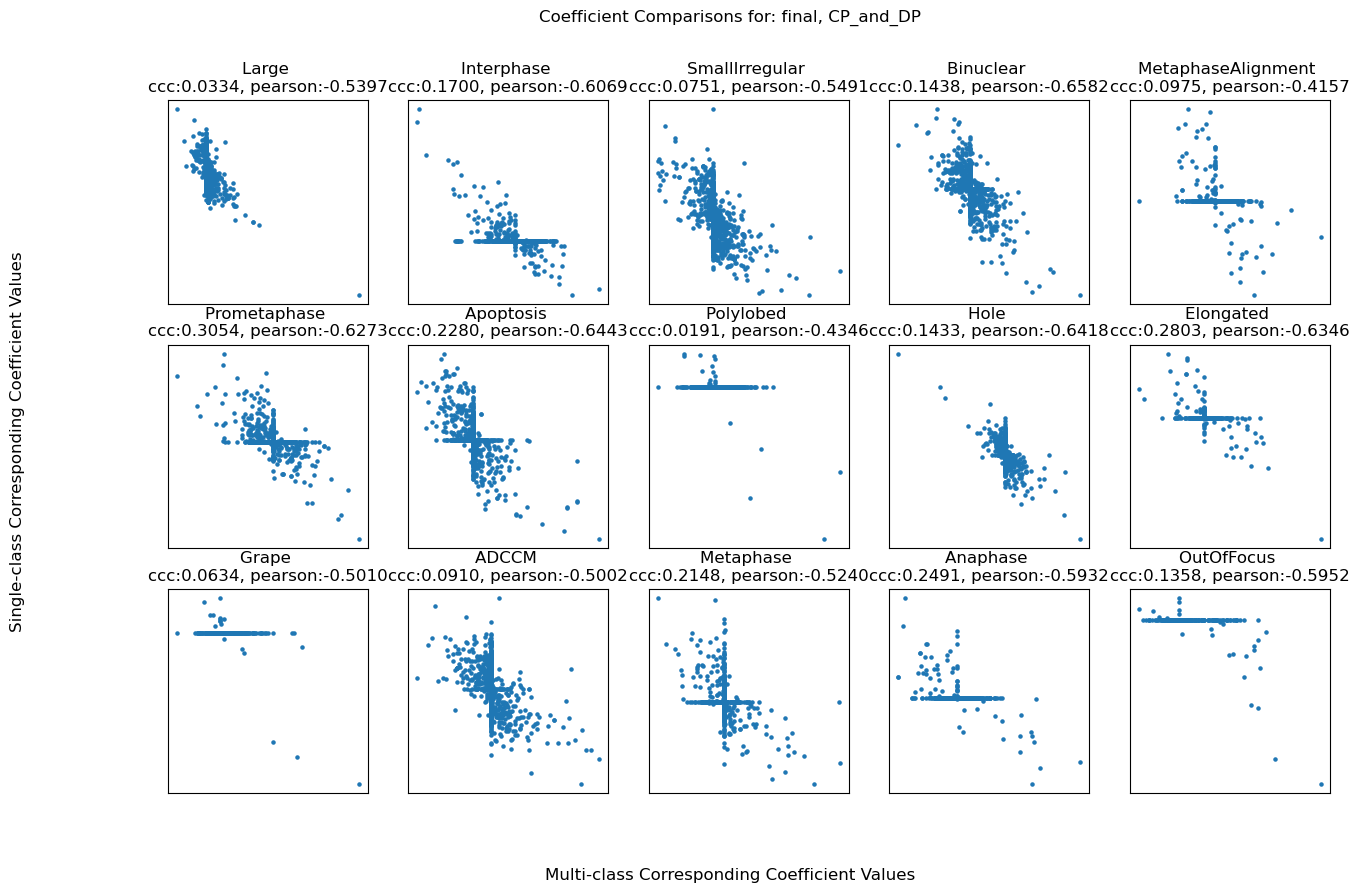

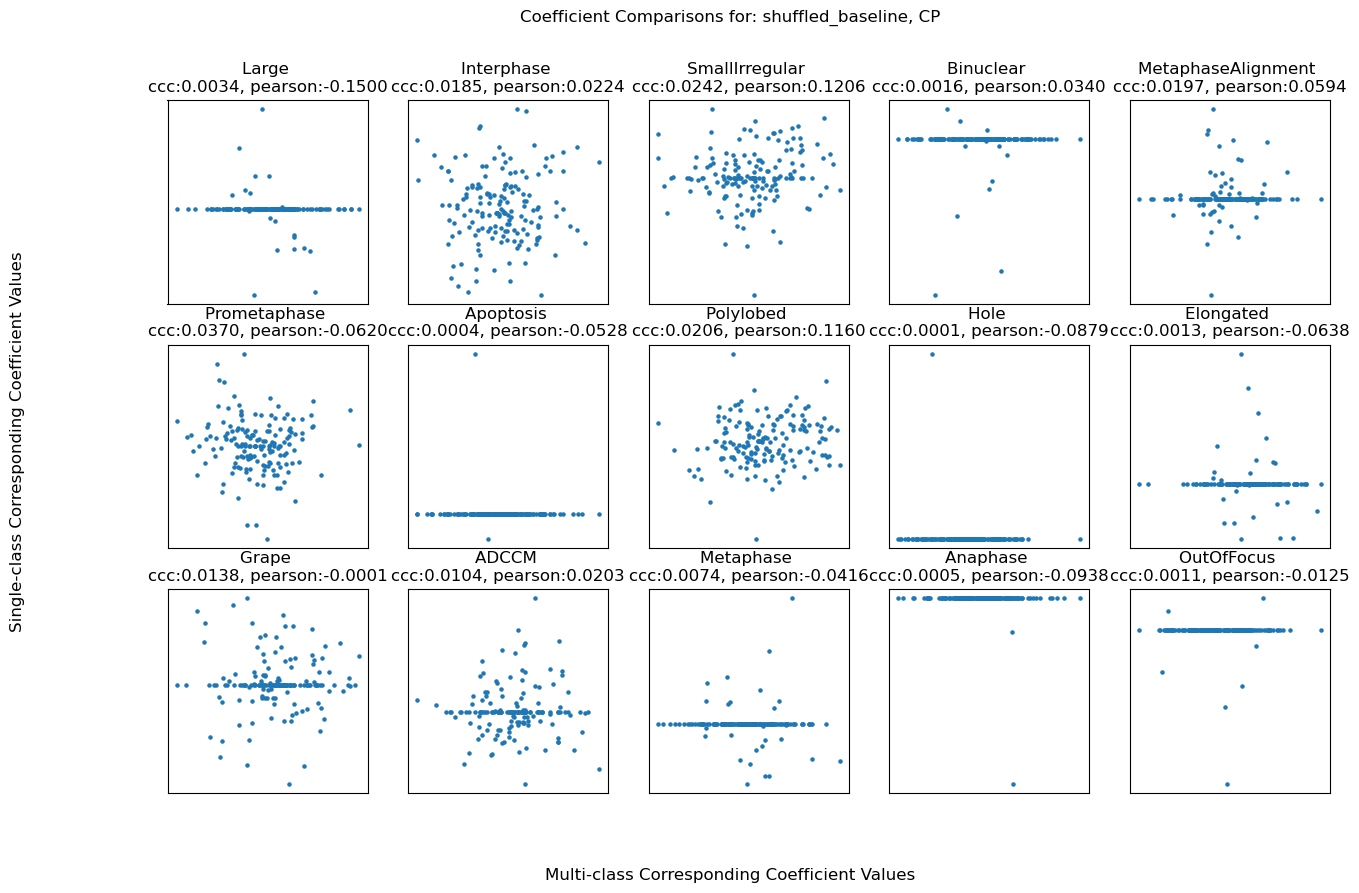

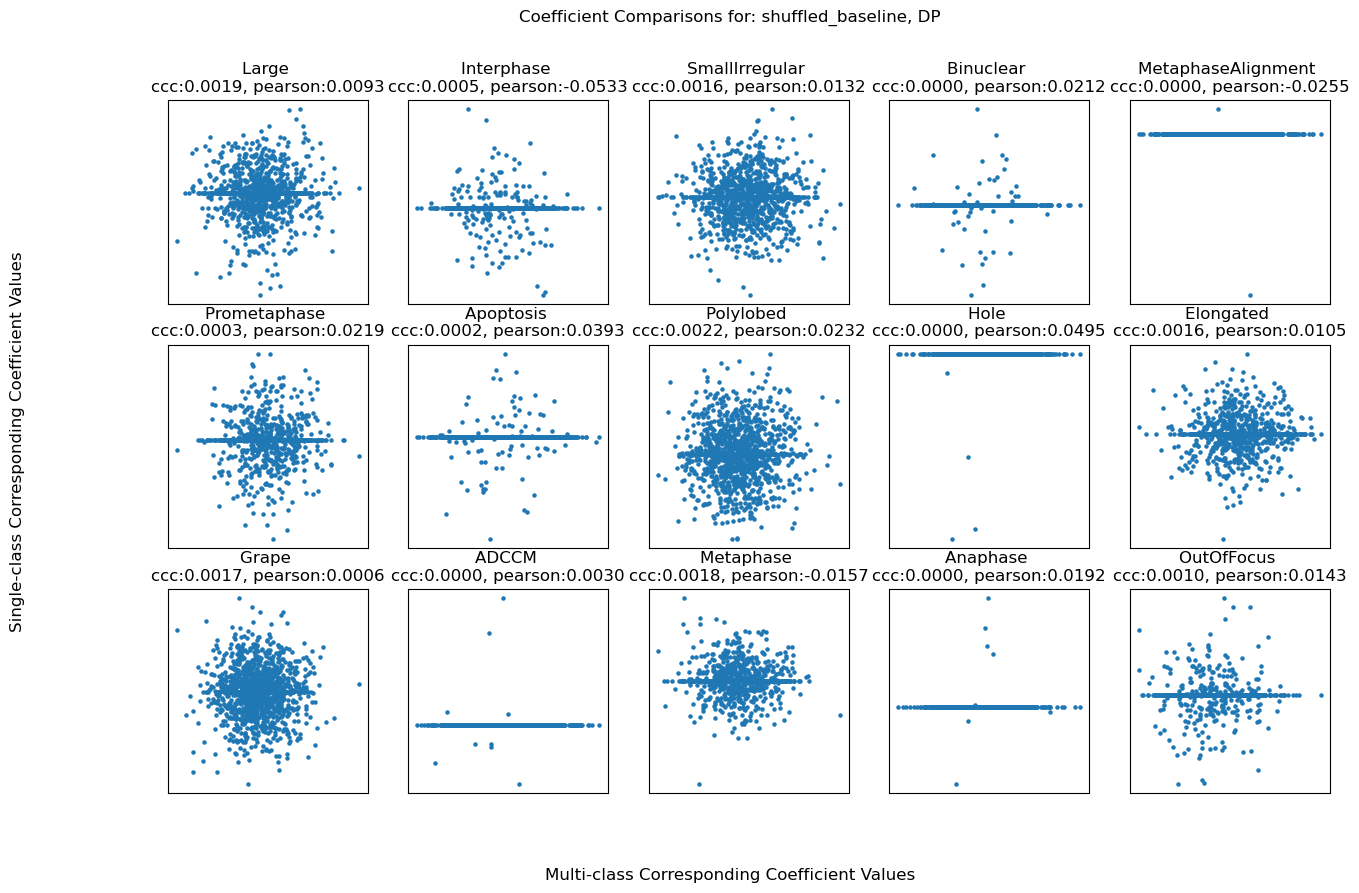

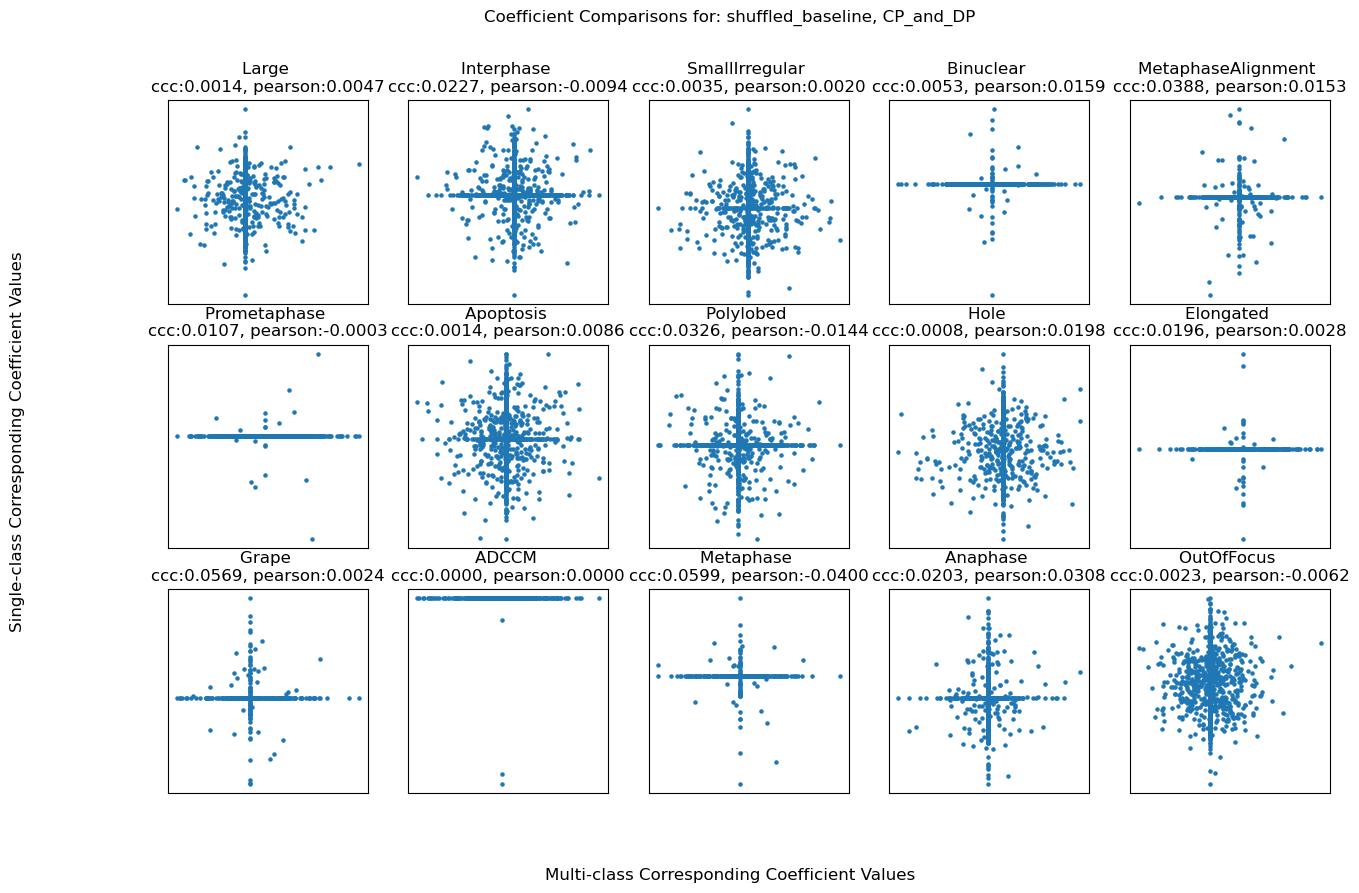

In [3]:
# directories to load the models from
multi_class_models_dir = pathlib.Path("../2.train_model/models/multi_class_models/")
single_class_models_dir = pathlib.Path("../2.train_model/models/single_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_correlations = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
phenotypic_classes = labeled_data["Mitocheck_Phenotypic_Class"].unique()

# iterate through each combination of feature_types, evaluation_types, phenotypic_classes
for model_type, feature_type in itertools.product(model_types, feature_types):
    # create a figure that has 3x5 subplots for 15 phenotypic classes
    fig, axs = plt.subplots(3, 5)
    fig.set_size_inches(15, 9)
    # variables to keep track of figure subplot coordinates
    ax_x = 0
    ax_y = 0

    # get multi class model coefficients for this combination of model type, feature type
    multi_class_model_path = pathlib.Path(
        f"{multi_class_models_dir}/{model_type}__{feature_type}.joblib"
    )
    multi_class_model = load(multi_class_model_path)
    multi_class_coeffs = pd.DataFrame(multi_class_model.coef_).T
    multi_class_coeffs.columns = multi_class_model.classes_

    # get multi class model coefficients for this combination of model type, feature type
    for phenotypic_class in phenotypic_classes:
        # load single class model for this combination of model type, feature type
        single_class_model_path = pathlib.Path(
            f"{single_class_models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        single_class_model = load(single_class_model_path)

        # get model coefficients
        single_class_specific_coefs = single_class_model.coef_

        # find corresponding coefficient values
        scatter_x = multi_class_coeffs[phenotypic_class].to_numpy()
        scatter_y = single_class_specific_coefs[0]

        # plot scatter subplot for this phenotypic class
        axs[ax_x, ax_y].scatter(scatter_x, scatter_y, s=5)
        # turn off ticks for axes
        axs[ax_x, ax_y].set_xticks([])
        axs[ax_x, ax_y].set_yticks([])

        # get clustermap correlation coefficient (ccc)
        ccc_corr = ccc(scatter_x, scatter_y)
        ccc_corr_string = "{:.4f}".format(ccc_corr)

        # get pearson correlation with numpy
        pearson_corr = np.corrcoef(scatter_x, scatter_y)[0][
            1
        ]  # numpy output is 2x2 correlation matrix, we only need top right value (same as bottom left)
        pearson_corr_string = "{:.4f}".format(pearson_corr)

        # label graph with phenotypic class and correlations
        axs[ax_x, ax_y].set_title(
            f"{phenotypic_class} \nccc:{ccc_corr_string}, pearson:{pearson_corr_string}"
        )

        # add coefficient correlations to compiled dataframe
        compiled_correlations.append(
            {
                "Phenotypic_Class": phenotypic_class,
                "shuffled": "shuffled" in model_type,
                "feature_type": feature_type,
                "CCC": ccc_corr,
                "Pearson": pearson_corr,
            }
        )

        # increase row coordinate counter (this marks which subplot to plot on in vertical direction)
        ax_x += 1
        # if row coordinate counter is at maximum (3 rows of subplots)
        if ax_x == 3:
            # set row coordinate counter to 0
            ax_x = 0
            # increase column coordinate counter (this marks which subplot to plot on in horizontal direction)
            ax_y += 1

    # add title and axes labels to figure
    fig.suptitle(f"Coefficient Comparisons for: {model_type}, {feature_type}")
    fig.supxlabel("Multi-class Corresponding Coefficient Values")
    fig.supylabel("Single-class Corresponding Coefficient Values")
    plt.plot()


In [4]:
# compile list of data into one dataframe
compiled_correlations = pd.DataFrame(compiled_correlations).reset_index(drop=True)

# make data tidy (CCC and Pearson get their own rows with their values instead of sharing a row)
compiled_correlations = pd.melt(
    compiled_correlations,
    id_vars=["Phenotypic_Class", "shuffled", "feature_type"],
    value_vars=["CCC", "Pearson"],
    var_name="Correlation_Type",
    value_name="Correlation_Value",
)

# specify results directory
correlations_dir = pathlib.Path("correlations/")
correlations_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_correlations_save_path = pathlib.Path(
    f"{correlations_dir}/compiled_coefficient_correlations.tsv"
)

# save data as tsv
compiled_correlations.to_csv(compiled_correlations_save_path, sep="\t")

# preview tidy data
compiled_correlations

,Phenotypic_Class,shuffled,feature_type,Correlation_Type,Correlation_Value
0,Large,False,CP,CCC,0.040336
1,Prometaphase,False,CP,CCC,0.327430
2,Grape,False,CP,CCC,0.248457
3,Interphase,False,CP,CCC,0.589933
4,Apoptosis,False,CP,CCC,0.263872
...,...,...,...,...,...
175,Hole,True,CP_and_DP,Pearson,0.019777
176,Anaphase,True,CP_and_DP,Pearson,0.030819
177,MetaphaseAlignment,True,CP_and_DP,Pearson,0.015298
178,Elongated,True,CP_and_DP,Pearson,0.002785
